In [22]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from sklearn import preprocessing
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sn
from scipy.stats import pearsonr

In [23]:
POP = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/data_clean/POP.csv')
GDR = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/data_clean/GDR.csv')
URB = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/data_clean/URB.csv')
EDU = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/data_clean/EDU.csv')
FAM = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/data_clean/FAM.csv')
GEN = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/data_clean/GEN.csv')
GDP = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/data_clean/GDP.csv')
RES = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/data_clean/RES.csv')
PRI = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/data_clean/PRI.csv')
SAL = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/data_clean/SAL.csv')
STO = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/data_clean/STO.csv')
URBC = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/CASA0007/data_clean/URBC.csv')

In [33]:
def min_max_scaler(x):
  return ((x-min(x))/(max(x)-min(x)))*100

def extract(i):
  POPi = POP[i]
  GDRi = GDR[i]
  URBi = URB[i]
  EDUi = EDU[i]
  FAMi = FAM[i]
  GENi = GEN[i]
  STOi = STO[i]
  GDPi = GDP[i]
  RESi = RES[i]
  PRIi = PRI[i]
  SALi = SAL[i]
  URBCi = URBC[i]

  POPii = min_max_scaler(POPi)  
  GDRii = min_max_scaler(GDRi)  
  URBii = min_max_scaler(URBi)  
  EDUii = min_max_scaler(EDUi)  
  FAMii = min_max_scaler(FAMi)  
  GENii = min_max_scaler(GENi)  
  STOii = min_max_scaler(STOi)  
  GDPii = min_max_scaler(GDPi)  
  RESii = min_max_scaler(RESi)  
  PRIii = min_max_scaler(PRIi) 
  SALii = min_max_scaler(SALi)  
  URBCii = min_max_scaler(URBCi)

  SETi1 = pd.DataFrame({'POP':POPi, 'URB':URBi, 'STO':STOi})
  SETi2 = pd.DataFrame({'GDR':GDRi, 'EDU':EDUi, 'FAM':FAMi, 'PRI':STOi, 'RES':RESi})
  
  return SETi1, SETi2

province = ['Shanghai','Jiangxi']

for i in province:
  SET = extract(i)
  SET1 = SET[0]
  SET2 = SET[1]
  
print(SET1)

     POP    URB       STO
0   4517  61.46  77826.12
1   4519  60.43  71144.86
2   4516  59.08  65291.81
3   4513  57.35  59612.83
4   4511  55.71  54223.83
5   4496  53.98  49258.86
6   4485  52.31  45118.31
7   4480  50.56  41972.48
8   4476  49.04  39197.26
9   4475  47.40  36351.22
10  4474  45.75  34225.32
11  4462  44.06  32068.55
12  4432  43.19  29802.83
13  4400  41.36  27694.76
14  4368  39.81  26089.90
15  4339  38.67  24052.03
16  4311  37.00  22416.77
17  4284  35.02  20962.26
18  4254  33.10  19975.34
19  4222  31.23  19281.81


In [34]:
OLS_y = SET1['STO']
OLS_x = SET1.drop(labels=['STO'], axis=1)
OLSi = sm.OLS(endog = OLS_y, exog = sm.add_constant(OLS_x)).fit()
OLSi.summary()

c:\Users\xianl\AppData\Local\ESRI\conda\envs\arcpy\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    STO   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     422.2
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           3.23e-15
Time:                        00:43:17   Log-Likelihood:                -184.41
No. Observations:                  20   AIC:                             374.8
Df Residuals:                      17   BIC:                             377.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.016e+05   6.88e+04      5.835      0.000    2.56e+05    5.47e+05
POP         -112.4930     17.276     -6.511      0.000    -148.943     -76.043
URB         2907.8936    177.032     16.426      0.000    2534.389    3281.398
==============================================================================
Omnibus:                        1.066   Durbin-Watson:                   0.464
Prob(Omnibus):                  0.587   Jarque-Bera (JB):                0.738
Skew:                           0.452   Prob(JB):                        0.691
Kurtosis:                       2.740   Cond. No.                     5.14e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
OLS_y = SET2['RES']
OLS_x = SET2.drop(labels=['RES'], axis=1)
OLSi = sm.OLS(endog = OLS_y, exog = sm.add_constant(OLS_x)).fit()
OLSi.summary()

c:\Users\xianl\AppData\Local\ESRI\conda\envs\arcpy\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RES   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     159.0
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           4.36e-12
Time:                        00:44:10   Log-Likelihood:                -140.69
No. Observations:                  20   AIC:                             291.4
Df Residuals:                      15   BIC:                             296.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4840.9453   3494.457     -1.385      0.186   -1.23e+04    2607.314
GDR           27.0970     32.351      0.838      0.415     -41.858      96.052
EDU          -62.5397     77.416     -0.808      0.432    -227.547     102.468
FAM          724.9518    642.688      1.128      0.277    -644.905    2094.809
PRI            0.1152      0.013      9.111      0.000       0.088       0.142
==============================================================================
Omnibus:                        0.390   Durbin-Watson:                   1.389
Prob(Omnibus):                  0.823   Jarque-Bera (JB):                0.086
Skew:                          -0.157   Prob(JB):                        0.958
Kurtosis:                       2.926   Cond. No.                     2.17e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

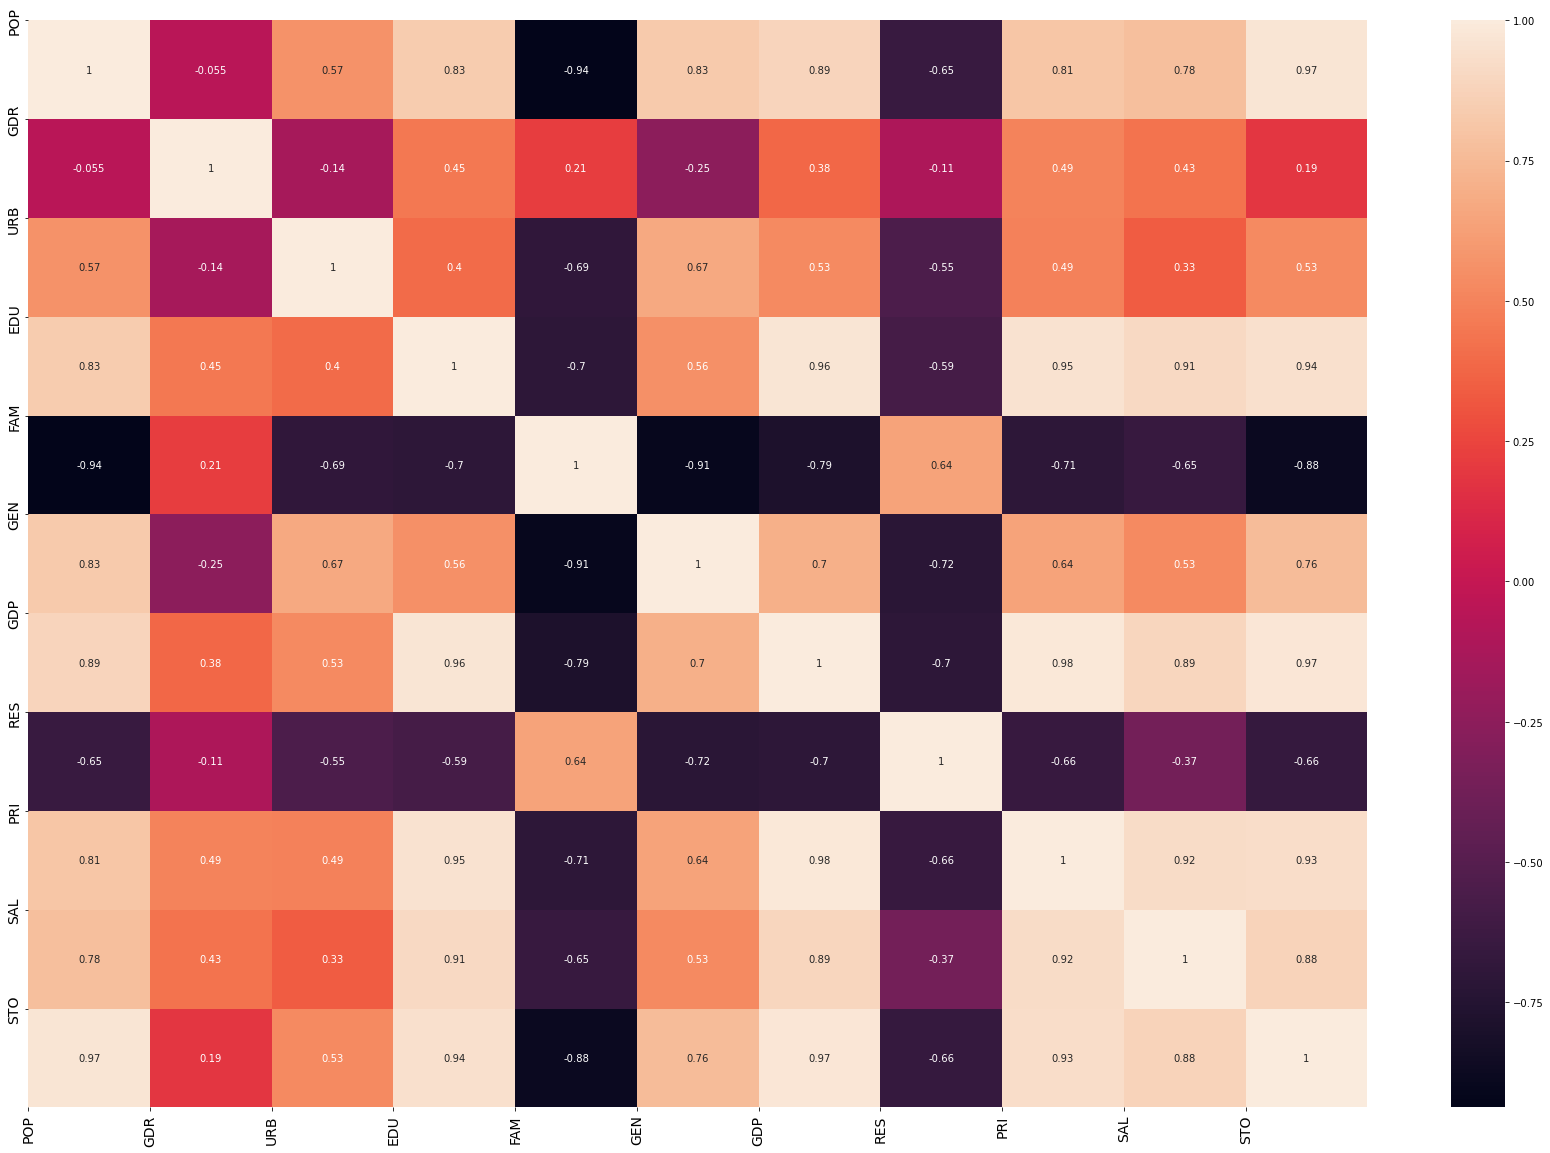

In [41]:
f = plt.figure(figsize=(30, 20))
sn.heatmap(SETii.corr(),annot=True)
plt.xticks(range(SETii.shape[1]), SETii.columns, fontsize=14, rotation=90)
plt.yticks(range(SETii.shape[1]), SETii.columns, fontsize=14)
plt.show()